The data format of caffe2 is DB(lmdb,minidb,etc), a key-value storage mode. Key is randomly generated and Value is real data

In [1]:
%matplotlib inline
import urllib2 # used for download data from the Internet
import numpy as np
import matplotlib.pyplot as plt
from StringIO import StringIO
from caffe2.python import core,utils,workspace
from caffe2.proto import caffe2_pb2

In [5]:
f = urllib2.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
raw_data = f.read()
print('Raw data looks like this:')
print(type(raw_data))
print(raw_data[:100] + '...')

Raw data looks like this:
<type 'str'>
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,...


In [10]:
# StringIO object is just like a file object initialized by raw_data
features = np.loadtxt(StringIO(raw_data),dtype=np.float32, delimiter=',',usecols=(0, 1, 2, 3))
label_converter = lambda s : {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}[s] # return value of dict according to its key s
# print label_converter('Iris-setosa')
labels = np.loadtxt(StringIO(raw_data), dtype=np.int, delimiter=',', usecols=(4,), converters={4: label_converter}) # 'converters' param convert the value of the 4th col into label
# print labels

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


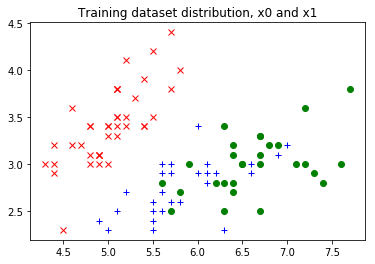

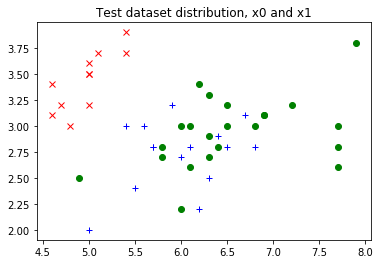

In [16]:
# Split the Iris dataset into train/val
random_index = np.random.permutation(150)
features = features[random_index]
labels = labels[random_index]
train_features = features[:100]
train_labels = labels[:100]
test_features = features[100:]
test_labels = labels[100:]
# Visualize train/val data
legend = ['rx', 'b+', 'go']
plt.title("Training dataset distribution, x0 and x1")
for i in range(3):
    plt.plot(train_features[train_labels == i, 0], train_features[train_labels == i, 1], legend[i])
plt.figure()
plt.title("Test dataset distribution, x0 and x1")
for i in range(3):
    plt.plot(test_features[test_labels == i, 0], test_features[test_labels == i, 1], legend[i])

In [17]:
# First, let's see how one can construct a TensorProtos protocol buffer from numpy arrays.
feature_and_label = caffe2_pb2.TensorProtos()
feature_and_label.protos.extend([
    utils.NumpyArrayToCaffe2Tensor(features[0]),
    utils.NumpyArrayToCaffe2Tensor(labels[0])])
print('This is what the tensor proto looks like for a feature and its label:')
print(str(feature_and_label))
print('This is the compact string that gets written into the db:')
print(feature_and_label.SerializeToString())

This is what the tensor proto looks like for a feature and its label:
protos {
  dims: 4
  data_type: FLOAT
  float_data: 5.80000019073
  float_data: 2.70000004768
  float_data: 4.09999990463
  float_data: 1.0
}
protos {
  data_type: INT32
  int32_data: 1
}

This is the compact string that gets written into the db:

���@��,@33�@  �?
"


In [23]:
def write_db(db_type, db_name, features, labels):
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(features.shape[0]):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([utils.NumpyArrayToCaffe2Tensor(features[i]),
                                       utils.NumpyArrayToCaffe2Tensor(labels[i])])
        transaction.put('train_%3d' %i, feature_and_label.SerializeToString()) # train_i is DB key,feature_and_label is DB value
    # Close the transaction, and then close the db
    del transaction
    del db

write_db('minidb', 'iris_train.minidb', train_features, train_labels)
write_db('minidb', 'iris_test.minidb', test_features, test_labels)

In [3]:
# Create a net to input iris minidb 
net_proto = core.Net('example_reader')
dbreader = net_proto.CreateDB([], 'dbreader', db='iris_train.minidb', db_type='minidb')
net_proto.TensorProtosDBInput([dbreader], ['X', 'Y'], batch_size=16)

print "The net looks like this:"
print(str(net_proto.Proto()))

The net looks like this:
name: "example_reader"
op {
  output: "dbreader"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "minidb"
  }
  arg {
    name: "db"
    s: "iris_train.minidb"
  }
}
op {
  input: "dbreader"
  output: "X"
  output: "Y"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 16
  }
}



In [6]:
workspace.CreateNet(net_proto, overwrite=True)
# Run first time to get first batch of data
workspace.RunNet(net_proto)
print("The first batch of feature is:")
print workspace.FetchBlob('X')
print("The first batch of label is:")
print workspace.FetchBlob('Y')

The first batch of feature is:
[[5.8 2.7 4.1 1. ]
 [4.4 2.9 1.4 0.2]
 [7.4 2.8 6.1 1.9]
 [6.9 3.2 5.7 2.3]
 [5.8 4.  1.2 0.2]
 [6.2 2.8 4.8 1.8]
 [7.2 3.6 6.1 2.5]
 [5.  2.3 3.3 1. ]
 [5.1 3.8 1.6 0.2]
 [5.5 4.2 1.4 0.2]
 [5.2 3.5 1.5 0.2]
 [6.6 2.9 4.6 1.3]
 [6.3 2.8 5.1 1.5]
 [5.  3.4 1.5 0.2]
 [6.3 2.3 4.4 1.3]
 [4.4 3.  1.3 0.2]]
The first batch of label is:
[1 0 2 2 0 2 2 1 0 0 0 1 2 0 1 0]
